<a href="https://colab.research.google.com/github/g-nightingale/misc-analysis/blob/master/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Using RNNs

**Author:** Geoff Nightingale <br>
**Date Created:** 06/08/2019 <br>
**Purpose:** Predict stock price movements using RNNs <br>


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import yfinance as yf 

from keras.models import Sequential
from keras.layers import Activation, Dense, GRU
from keras.layers import Dropout
from keras import optimizers as ko

stock = 'CEN.NZ'
start_dt = '2019-01-01'
end_dt = '2020-05-12'


## 1. Data prep and checks

#### Get the stock data

In [0]:
# Get stock data from yahoo finance
price_data = yf.download(stock, start_dt, end_dt)
price_data = price_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [0]:
# Check the data
print(price_data.shape, '\n')
print(price_data.head(), '\n')
print(price_data.tail(), '\n')

(341, 7) 

        Date  Open  High   Low  Close  Adj Close  Volume
0 2019-01-03  5.86  5.93  5.86   5.88   5.429158  930601
1 2019-01-04  5.86  5.92  5.86   5.88   5.429158  163081
2 2019-01-07  5.92  6.00  5.82   6.00   5.539956  474339
3 2019-01-08  5.99  6.00  5.92   6.00   5.539956  427774
4 2019-01-09  6.01  6.04  6.00   6.04   5.576889  776208 

          Date  Open  High   Low  Close  Adj Close   Volume
336 2020-05-06  6.26  6.30  6.13   6.22       6.22   658394
337 2020-05-07  6.30  6.30  6.20   6.21       6.21   853264
338 2020-05-08  6.26  6.34  6.26   6.29       6.29  1218333
339 2020-05-11  6.30  6.38  6.26   6.26       6.26  1109413
340 2020-05-12  6.30  6.45  6.30   6.35       6.35  1129367 



In [0]:
# Generate return vars
price_data['return_m1'] = price_data['Close'].pct_change(periods=1)
price_data['return_p1'] = price_data['return_m1'].shift(-1)
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,return_m1,return_p1
0,2019-01-03,5.86,5.93,5.86,5.88,5.429158,930601,NaN,0.000000
1,2019-01-04,5.86,5.92,5.86,5.88,5.429158,163081,0.000000,0.020408
2,2019-01-07,5.92,6.00,5.82,6.00,5.539956,474339,0.020408,0.000000
3,2019-01-08,5.99,6.00,5.92,6.00,5.539956,427774,0.000000,0.006667
4,2019-01-09,6.01,6.04,6.00,6.04,5.576889,776208,0.006667,0.001656


C:\Users\danaq\Miniconda3\envs\minimal_ds\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


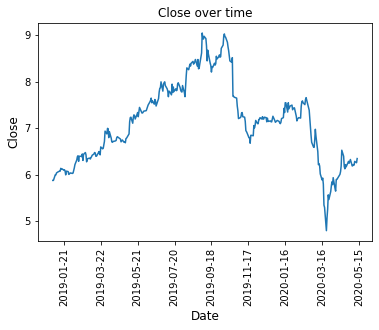

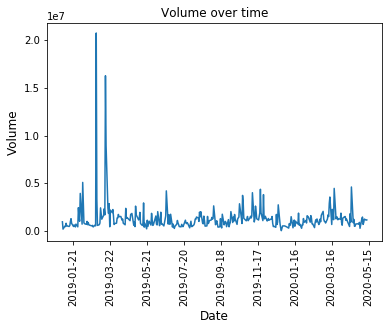

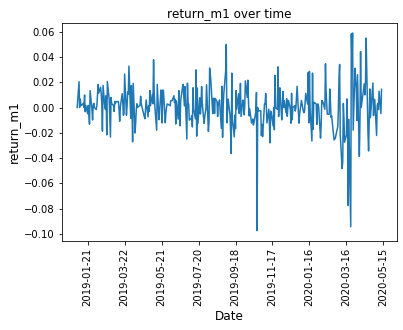

In [0]:
# Plot vars
plt_vars = ['Close', 'Volume', 'return_m1']

for var in plt_vars:
    plt.figure()
    plt.title(var + ' over time')
    plt.plot(price_data['Date'], price_data[var])
    plt.xlabel('Date', fontsize=12)
    plt.xticks(rotation=90)
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.ylabel(var, fontsize=12)
    plt.show()

In [0]:
# Drop na
price_data = price_data.dropna()
#price_data = price_data[price_data['Date']>='2017-01-01'].reset_index()
print(price_data.shape)

(339, 9)


## 2. Split Train & Test Sets

In [0]:
train_pct = 0.6
train_n = int(price_data.shape[0] * train_pct)

x_train = price_data[:train_n]
x_test =  price_data[train_n:].reset_index(drop=True)

print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (203, 9)
x_test shape:  (136, 9)


## 3. Create Training Samples

#### Price only model

In [0]:
ex = 1000
n = 20

# Create training set sequences
x_train1 = np.zeros((ex,n))
y_train1= np.zeros((ex,1))

for i in range(ex):
    r = random.randrange(n, x_train.shape[0])
    x = x_train['return_m1'][r-n:r].tolist()
    y = x_train['return_p1'][r]

    x_train1[i,:] = x
    y_train1[i,:] = y
    
print('x_train1 shape: ', x_train1.shape)
print('y_train1 shape: ', y_train1.shape)

# Create test set sequences
ts = x_test.shape[0]-n
x_test1 = np.zeros((ts,n))
y_test1= np.zeros((ts,1))

for i in range(x_test.shape[0]-n):
    x = x_test['return_m1'][i:i+n].tolist()
    y = x_test['return_p1'][i+n-1]

    x_test1[i,:] = x
    y_test1[i,:] = y
    
print('x_test1 shape: ', x_test1.shape)
print('y_test1 shape: ', y_test1.shape)

x_train1 shape:  (1000, 20)
y_train1 shape:  (1000, 1)
x_test1 shape:  (116, 20)
y_test1 shape:  (116, 1)


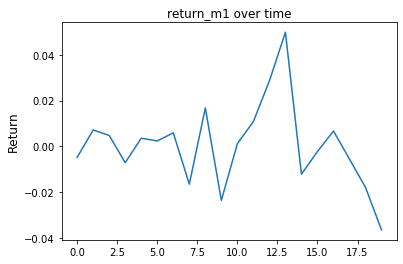

target: [0.02721899]


In [0]:
# Plot an example    
x = 10

plt.figure()
plt.title(var + ' over time')
plt.plot(x_train1[x])
plt.ylabel('Return', fontsize=12)
plt.show()

print('target:', y_train1[x])

#### Price and volume model

In [0]:
ex = 500
n = 20

# Create training set sequences
x_train1 = np.zeros((ex,2,n))
y_train1= np.zeros((ex,1))

for i in range(ex):
    r = random.randrange(n, x_train.shape[0])
    x1 = x_train['return_m1'][r-n:r].tolist()
    x2 = x_train['Volume'][r-n:r].tolist()
    y = x_train['return_p1'][r]

    x_train1[i,0,:] = x1
    x_train1[i,1,:] = x2
    y_train1[i,:] = y
    
print('x_train1 shape: ', x_train1.shape)
print('y_train1 shape: ', y_train1.shape)

# Create test set sequences
ts = x_test.shape[0]-n
x_test1 = np.zeros((ts,2,n))
y_test1= np.zeros((ts,1))

for i in range(x_test.shape[0]-n):
    x1 = x_test['return_m1'][i:i+n].tolist()
    x2 = x_test['Volume'][i:i+n].tolist()
    y = x_test['return_p1'][i+n-1]

    x_test1[i,0,:] = x1
    x_test1[i,1,:] = x2
    y_test1[i,:] = y
    
print('x_test1 shape: ', x_test1.shape)
print('y_test1 shape: ', y_test1.shape)

x_train1 shape:  (500, 2, 20)
y_train1 shape:  (500, 1)
x_test1 shape:  (116, 2, 20)
y_test1 shape:  (116, 1)


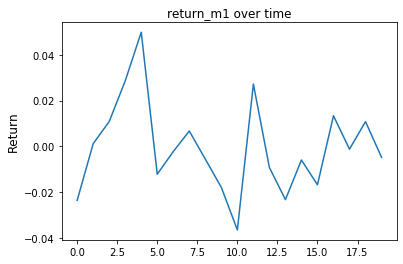

target: [0.0035886]


In [0]:
# Plot an example    
x = 0

plt.figure()
plt.title(var + ' over time')
plt.plot(x_train1[x][0][:])
plt.ylabel('Return', fontsize=12)
plt.show()

print('target:', y_train1[x])

#### Check train and test set distrbutions

return_m1


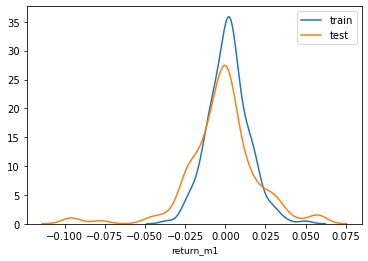


Volume


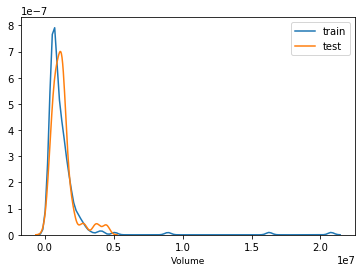

In [0]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    for feature in features:
        print(feature)
        plt.figure()
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        #plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        #plt.tick_params(axis='y', which='major', labelsize=6)
        plt.show();
        print()
    
plot_feature_distribution(x_train, x_test, 'train', 'test', ['return_m1','Volume'])

## 4. Create Model

#### Price only model

In [0]:
x_train2 = np.reshape(x_train1, (x_train1.shape[0], 1, x_train1.shape[1]))
x_test2 = np.reshape(x_test1, (x_test1.shape[0], 1, x_test1.shape[1]))

def gru_model():
    model = Sequential()
    model.add(GRU(32, input_shape = (1,x_train2.shape[1]), return_sequences = True))
    #model.add(GRU(32, return_sequences = True))
    model.add(GRU(8, return_sequences = False))
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    optimizer = ko.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6)
    model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = ['mae'])
    return model

model = gru_model()
model.summary()

ValueError: cannot reshape array of size 20000 into shape (500,1,2)

#### Price and volume model

In [0]:
x_train2 = np.reshape(x_train1, (x_train1.shape[0], 2, x_train1.shape[2]))
x_test2 = np.reshape(x_test1, (x_test1.shape[0], 2, x_test1.shape[2]))

def gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape = (2,x_train2.shape[2]), return_sequences = True))
    #model.add(Dropout(0.2))
    model.add(GRU(32, return_sequences = True))
    #model.add(Dropout(0.2))
    model.add(GRU(16, return_sequences = False))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    optimizer = ko.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6)
    model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = ['mae'])
    return model

model = gru_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 2, 64)             16320     
_________________________________________________________________
gru_2 (GRU)                  (None, 2, 32)             9312      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 28,001
Trainable params: 28,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Fit the model
model.fit(x_train2, y_train1, batch_size=64, epochs=1000, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 3s - loss: 0.0051 - mean_absolute_error: 0.0549
Epoch 2/1000
 - 0s - loss: 0.0019 - mean_absolute_error: 0.0336
Epoch 3/1000
 - 0s - loss: 0.0011 - mean_absolute_error: 0.0262
Epoch 4/1000
 - 0s - loss: 6.4673e-04 - mean_absolute_error: 0.0205
Epoch 5/1000
 - 0s - loss: 4.4029e-04 - mean_absolute_error: 0.0169
Epoch 6/1000
 - 0s - loss: 3.3181e-04 - mean_absolute_error: 0.0145
Epoch 7/1000
 - 0s - loss: 2.5250e-04 - mean_absolute_error: 0.0124
Epoch 8/1000
 - 0s - loss: 2.0152e-04 - mean_absolute_error: 0.0110
Epoch 9/1000
 - 0s - loss: 1.9391e-04 - mean_absolute_error: 0.0109
Epoch 10/1000
 - 0s - loss: 1.7664e-04 - mean_absolute_error: 0.0103
Epoch 11/1000
 - 0s - loss: 1.5417e-04 - mean_absolute_error: 0.0096
Epoch 12/1000
 - 0s - loss: 1.3989e-04 - mean_absolute_error: 0.0092
Epoch 13/1000
 - 0s - loss: 1.2291e-04 - mean_absolute_error: 0.0085
Epoch 14/1000
 - 0s - loss: 1.1049e-04 - mean_absolute_error: 0.0079
Epoch 1

## 5. Model Performance

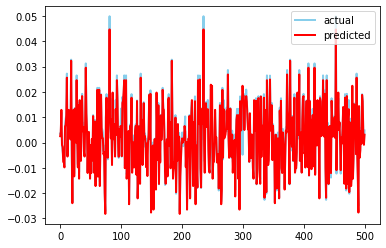

In [0]:
y_hat = model.predict(x_train2)

plt.figure()
plt.plot(y_train1, color='skyblue', linewidth=2, label='actual')
plt.plot(y_hat, color='red', linewidth=2, label='predicted')
plt.legend()
plt.show()

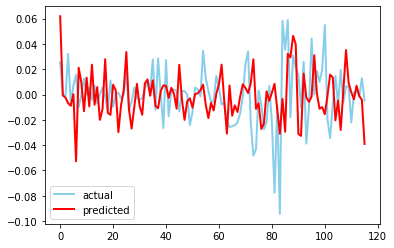

In [0]:
y_hat_test = model.predict(x_test2)

plt.figure()
plt.plot(y_test1, color='skyblue', linewidth=2, label='actual')
plt.plot(y_hat_test, color='red', linewidth=2, label='predicted')
plt.legend()


#### Indexed Return Analysis

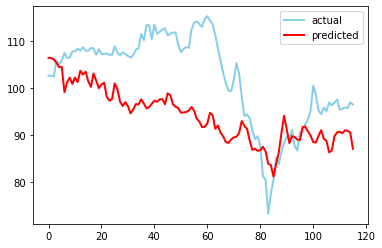

In [0]:
start = 0
end = 1000

index = pd.DataFrame()
index['y_hat_test'] = y_hat_test[start:end].flatten()
index['y_test'] = y_test1[start:end]
index['y_hat_test_index'] = 100*np.exp(np.nan_to_num(index['y_hat_test'].cumsum()))
index['y_test_index'] = 100*np.exp(np.nan_to_num(index['y_test'].cumsum()))

plt.figure()
plt.plot(index['y_test_index'], color='skyblue', linewidth=2, label='actual')
plt.plot(index['y_hat_test_index'], color='red', linewidth=2, label='predicted')
plt.legend()
plt.show()

#### Confusion matrix

In [0]:
index['y_test'].describe()

count    116.000000
mean      -0.000309
std        0.022365
min       -0.094340
25%       -0.009886
50%        0.000000
75%        0.010289
max        0.058935
Name: y_test, dtype: float64

In [0]:
def return_bin(df,var):
    if df[var] <= -0.01:
        return -0.01
    elif df[var] >= 0.01:
        return 0.01
    else:
        return 0 

index['y_test_bin'] = index.apply(return_bin, args=['y_test'], axis=1)
index['y_hat_test_bin'] = index.apply(return_bin, args=['y_hat_test'], axis=1)

In [0]:
classes = [-0.01,0.0,0.01]

cross_tab = pd.crosstab(index=index['y_test_bin'],columns=index['y_hat_test_bin'],margins=True)

print('Prediction Volumes')
print(cross_tab)
print()
print('Prediction Percentages')
print(cross_tab/cross_tab.loc['All','All'])
print()
for c in classes:
    print('precision ', c, ': ', cross_tab.loc[c,c]/cross_tab.loc['All',c]) # TP x/predicted x
    print('recall ', c, ': ', cross_tab.loc[c,c]/cross_tab.loc[c,'All']) # TP x/actual x

Prediction Volumes
y_hat_test_bin  -0.01  0.0  0.01  All
y_test_bin                           
-0.01              10   15     4   29
0.0                14   36     8   58
0.01                9   12     8   29
All                33   63    20  116

Prediction Percentages
y_hat_test_bin     -0.01       0.0      0.01   All
y_test_bin                                        
-0.01           0.086207  0.129310  0.034483  0.25
0.0             0.120690  0.310345  0.068966  0.50
0.01            0.077586  0.103448  0.068966  0.25
All             0.284483  0.543103  0.172414  1.00

precision  -0.01 :  0.30303030303030304
recall  -0.01 :  0.3448275862068966
precision  0.0 :  0.5714285714285714
recall  0.0 :  0.6206896551724138
precision  0.01 :  0.4
recall  0.01 :  0.27586206896551724


### Checking data integrity

In [0]:
#----- create test set sequences
n = 20
r = 20

x1 = x_train['return_m1'][r-n:r].tolist()
y = x_train['return_p1'][r]
    
print(x1)
print(y)
    

In [0]:
x_train.head(30)

,Date,Open,High,Low,Close,Adj Close,Volume,return_m1,return_p1
1,2019-01-03,191.00,199.95,189.90,199.35,196.00,44356508,0.040720,-0.009782
2,2019-01-04,199.45,200.40,196.60,197.40,194.08,31051265,-0.009782,0.025836
3,2019-01-07,198.30,203.00,197.55,202.50,199.09,44425553,0.025836,0.027654
4,2019-01-08,202.00,211.30,201.00,208.10,204.60,38996490,0.027654,0.017780
5,2019-01-09,213.00,214.90,209.00,211.80,208.24,36057434,0.017780,0.021719
6,2019-01-10,213.80,218.80,211.90,216.40,212.76,39662599,0.021719,0.007394
7,2019-01-11,216.40,219.20,214.20,218.00,214.33,27475496,0.007394,0.000000
8,2019-01-14,217.00,219.30,215.50,218.00,214.33,32794981,0.000000,0.000459
9,2019-01-15,219.00,219.50,215.20,218.10,214.43,35674865,0.000459,0.010546
10,2019-01-16,218.10,221.40,217.50,220.40,216.69,26295506,0.010546,-0.005898


In [0]:
y_train1

array([[-0.00666667],
       [-0.00171527],
       [-0.00169062],
       [ 0.00351648],
       [-0.0127186 ],
       [-0.01722689],
       [ 0.00172488],
       [ 0.0030648 ],
       [ 0.02891235],
       [ 0.00387764],
       [-0.00666667],
       [-0.01036683],
       [ 0.00644122],
       [ 0.00637213],
       [ 0.00623441],
       [ 0.0030648 ],
       [-0.00827166],
       [-0.00225225],
       [-0.00169062],
       [-0.00483286],
       [-0.01580334],
       [ 0.        ],
       [-0.01190965],
       [ 0.00644122],
       [-0.0068    ],
       [-0.00593066],
       [-0.00322321],
       [ 0.00353045],
       [ 0.00160449],
       [-0.00161681],
       [-0.01761168],
       [ 0.02615519],
       [-0.01190965],
       [ 0.01159536],
       [ 0.01460177],
       [ 0.02476269],
       [-0.0055336 ],
       [ 0.00860956],
       [-0.0068    ],
       [-0.00218627],
       [-0.01923937],
       [-0.01190965],
       [-0.0068    ],
       [ 0.00356824],
       [ 0.01545064],
       [ 0